# Homogeneous Operator Problem: True Solution vs Neural Network Prediction Visualization

This notebook is used to visualize the results of the Homogeneous operator problem, comparing the true solution with the QuanONet neural network predictions.

## Problem Description
- **Homogeneous operator problem**: Given original function $u_0(x)$, find the solution $u(x)$ that satisfies the differential equation $\frac{du}{dx} = u + u_0(x)$
- **Input**: Values of original function $u_0(x)$ at discrete points
- **Output**: Solution values $u(x)$ satisfying $\frac{du}{dx} = u + u_0(x)$ at corresponding points  
- **Objective**: Compare neural network predicted solution function values with true analytical solution values

**Mathematical relationship**: $\frac{du}{dx} = u + u_0(x)$, which is a first-order linear homogeneous operator

## 1. Import Required Libraries

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# MindSpore related imports
import mindspore as ms
import mindspore.nn as nn
import mindspore.numpy as mnp
from mindspore.train.serialization import load_checkpoint, load_param_into_net

# Local module imports - 修复导入路径
from core.models import QuanONet, HEAQNN
from core.quantum_circuits import generate_simple_hamiltonian
from data_utils.data_generation import generate_Homogeneous_Operator_data
from data_utils.data_processing import ODE_encode

# Set MindSpore environment
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")

# Set matplotlib Chinese font
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# Set plotting style - use stable seaborn style
try:
    plt.style.use('seaborn-whitegrid')
except OSError:
    try:
        plt.style.use('seaborn')
    except OSError:
        plt.style.use('default')

# Set seaborn color palette
try:
    sns.set_palette("husl")
except:
    pass

# Set image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print("✅ 库导入完成!")

[ERROR] ME(3961341:140104253843264,MainProcess):2025-08-05-04:43:07.959.750 [mindspore/run_check/_check_version.py:230] Cuda ['10.1', '11.1', '11.6'] version(libcudnn*.so need by mindspore-gpu) is not found. Please confirm that the path of cuda is set to the env LD_LIBRARY_PATH, or check whether the CUDA version in wheel package and the CUDA runtime in current device matches. Please refer to the installation guidelines: https://www.mindspore.cn/install


✅ 库导入完成!


## 2. Data Loading and Preprocessing

In [2]:
# Configuration parameters
def load_latest_config():
    """Load the latest configuration file"""
    config_files = list(Path("data").glob("Homogeneous_Operator_config_*.json"))
    if not config_files:
        print("❌ 未找到配置文件!")
        return None
    
    latest_config = max(config_files, key=os.path.getctime)
    with open(latest_config, 'r') as f:
        config = json.load(f)
    
    print(f"✅ 已加载配置文件: {latest_config}")
    return config

def load_Homogeneous_data(config):
    """Load homogeneous operator data"""
    # Build data file path
    data_file = f"data/Homogeneous_Operator_dataset_{config['num_train']}_{config['num_test']}_{config['num_sensors']}_{config['train_sample_num']}_{config['test_sample_num']}.npz"
    
    if not os.path.exists(data_file):
        print(f"❌ 数据文件不存在，正在生成: {data_file}")
        
        # First generate the raw data to get original functions
        train_u0, train_u, test_u0, test_u, x = generate_Homogeneous_Operator_data(
            config['num_train'], config['num_test'], config['num_sensors']
        )
        
        # Convert to numpy for saving
        test_u0_np = test_u0.asnumpy()  # Original function u0(x) (input)
        test_u_np = test_u.asnumpy()    # Solution function u(x) satisfying du/dx = u - u0²(x) (output/target)
        x_points = x.asnumpy()
        
        # Use ODE encoding for network training
        train_branch_input, train_trunk_input, train_output, \
        test_branch_input, test_trunk_input, test_output = ODE_encode(
            generate_Homogeneous_Operator_data,
            config['num_train'], config['num_test'], config['num_sensors'],
            config['train_sample_num'], config['test_sample_num']
        )
        
        # Save data including original functions
        np.savez_compressed(
            data_file,
            train_branch_input=train_branch_input.asnumpy(),
            train_trunk_input=train_trunk_input.asnumpy(),
            train_output=train_output.asnumpy(),
            test_branch_input=test_branch_input.asnumpy(),
            test_trunk_input=test_trunk_input.asnumpy(),
            test_output=test_output.asnumpy(),
            original_test_u0=test_u0_np,        # Original function u0(x) (input)
            original_test_u=test_u_np,          # Solution function u(x) satisfying du/dx = u - u0²(x) (output/target)
            x_points=x_points
        )
        print(f"✅ 数据已生成并保存")
    
    # Load data
    data = np.load(data_file, allow_pickle=True)
    
    return {
        'test_branch_input': ms.Tensor(data['test_branch_input'], ms.float32),
        'test_trunk_input': ms.Tensor(data['test_trunk_input'], ms.float32), 
        'test_output': ms.Tensor(data['test_output'], ms.float32),
        'original_test_u0': data['original_test_u0'] if 'original_test_u0' in data else None,  # Original function (input)
        'original_test_u': data['original_test_u'] if 'original_test_u' in data else None,    # Solution function (output)
        'x_points': data['x_points'] if 'x_points' in data else None
    }

# Load configuration and data
config = load_latest_config()
if config:
    data = load_Homogeneous_data(config)
    
    print(f"📊 数据加载完成 - 测试样本数: {data['test_branch_input'].shape[0]}")
else:
    print("❌ 请先运行训练脚本生成数据!")

✅ 已加载配置文件: data/Homogeneous_Operator_config_1000_1000_100_10_100.json
📊 数据加载完成 - 测试样本数: 100000


## 3. Model Loading and Setup

In [3]:
def load_trained_model(config, data):
    """Load the trained model"""
    # Find the best model file
    best_model_path = "checkpoints/best_Homogeneous_quanonet_QuanONet.ckpt"
    
    if not os.path.exists(best_model_path):
        print(f"❌ 模型文件不存在: {best_model_path}")
        return None
    
    # Create model
    ham = generate_simple_hamiltonian(config['num_qubits'])
    branch_input_size = data['test_branch_input'].shape[1]
    trunk_input_size = data['test_trunk_input'].shape[1]
    
    model = QuanONet(
        num_qubits=config['num_qubits'],
        branch_input_size=branch_input_size,
        trunk_input_size=trunk_input_size,
        net_size=tuple(config['net_size']),
        ham=ham,
        scale_coeff=config['scale_coeff'],
        if_trainable_freq=config.get('if_trainable_freq', False)
    )
    
    # Load model weights
    param_dict = load_checkpoint(best_model_path)
    load_param_into_net(model, param_dict)
    model.set_train(False)  # Set to evaluation mode
    
    print(f"✅ 模型加载成功: {config['model_type']}")
    
    return model

# Load model
if config and data:
    model = load_trained_model(config, data)
else:
    print("❌ 请先加载配置和数据!")

✅ 模型加载成功: QuanONet


## 4. Generate Prediction Results

In [4]:
def generate_predictions(model, data, batch_size=100):
    """Generate model predictions"""
    if model is None:
        print("❌ 模型未加载!")
        return None
    
    test_input = (data['test_branch_input'], data['test_trunk_input'])
    test_output = data['test_output']
    
    # Batch prediction to avoid memory issues
    test_size = test_input[0].shape[0]
    predictions = []
    
    print(f"🔮 开始预测 {test_size} 个测试样本...")
    
    for start in range(0, test_size, batch_size):
        end = min(start + batch_size, test_size)
        
        batch_branch = test_input[0][start:end]
        batch_trunk = test_input[1][start:end]
        batch_input = (batch_branch, batch_trunk)
        
        # Model prediction
        batch_pred = model(batch_input)
        predictions.append(batch_pred.asnumpy())
    
    # Merge all prediction results
    predictions = np.vstack(predictions)
    true_values = test_output.asnumpy()
    
    # Calculate error metrics
    mse = np.mean((predictions - true_values) ** 2)
    mae = np.mean(np.abs(predictions - true_values))
    max_error = np.max(np.abs(predictions - true_values))
    rel_error = np.mean(np.abs(predictions - true_values) / (np.abs(true_values) + 1e-8))
    
    print(f"✅ 预测完成!")
    print(f"📈 评估指标 - MSE: {mse:.6f}, MAE: {mae:.6f}")
    
    return {
        'predictions': predictions,
        'true_values': true_values,
        'mse': mse,
        'mae': mae,
        'max_error': max_error,
        'rel_error': rel_error
    }

# Generate prediction results
if model and data:
    results = generate_predictions(model, data)
else:
    print("❌ 请先加载模型和数据!")

🔮 开始预测 100000 个测试样本...
✅ 预测完成!
📈 评估指标 - MSE: 0.000198, MAE: 0.010350


## 5. Create Visualization Functions

In [ ]:
def plot_single_sample_comparison(sample_idx, data, results, config, save_path=None):
    """Plot comparison for a single sample with horizontal layout: original function, true vs predicted, error"""
    
    # Get prediction data
    samples_per_func = config['test_sample_num']
    start_idx = sample_idx * samples_per_func
    end_idx = start_idx + samples_per_func
    
    pred_u = results['predictions'][start_idx:end_idx].flatten()
    true_u = results['true_values'][start_idx:end_idx].flatten()
    pred_x = data['test_trunk_input'].asnumpy()[start_idx:end_idx].flatten()
    
    # Check if original function data is available
    has_original_data = (data.get('original_test_u0') is not None and 
                        data.get('original_test_u') is not None and 
                        data.get('x_points') is not None)
    
    if has_original_data:
        # Full comparison with original functions
        x_points = data['x_points']
        original_u0 = data['original_test_u0'][sample_idx]  # Input: original function u0(x)
        original_u = data['original_test_u'][sample_idx]    # Target: solution function u(x) satisfying du/dx = u - u0²(x)
        
        # Create horizontal layout with 3 subplots
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Subplot 1: Input original function u0(x)
        ax1.plot(x_points, original_u0, 'b-', linewidth=2, label='Original Function u₀(x)')
        ax1.scatter(pred_x, original_u0[np.searchsorted(x_points, pred_x)], 
                    c='blue', s=50, alpha=0.7, label='Sampling Points')
        ax1.set_xlabel('x')
        ax1.set_ylabel('u₀(x)')
        ax1.set_title(f'Sample {sample_idx}: Original Function u₀(x)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Subplot 2: True vs Predicted solution function
        ax2.plot(x_points, original_u, 'g-', linewidth=2, label='True Solution Function')
        ax2.scatter(pred_x, true_u, c='green', s=50, alpha=0.7, label='True Values')
        ax2.scatter(pred_x, pred_u, c='red', s=50, alpha=0.7, label='Predicted Values', marker='^')
        ax2.set_xlabel('x')
        ax2.set_ylabel('u(x)')
        ax2.set_title('True vs Predicted Solution Function')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Subplot 3: Error analysis
        errors = np.abs(pred_u - true_u)
        ax3.scatter(pred_x, errors, c='purple', s=50, alpha=0.7)
        ax3.plot(pred_x, errors, 'purple', alpha=0.5, linewidth=1)
        ax3.set_xlabel('x')
        ax3.set_ylabel('|Predicted - True|')
        ax3.set_title(f'Absolute Error (MAE: {np.mean(errors):.6f})')
        ax3.grid(True, alpha=0.3)
        
    else:
        # Use branch_input to reconstruct original function through interpolation
        print(f"⚠️ 原始函数数据不可用，通过 branch_input 插值重建输入函数")
        
        # Get branch input for this sample (input function values at sensor points)
        samples_per_func = config['test_sample_num']
        start_idx = sample_idx * samples_per_func
        branch_input = data['test_branch_input'].asnumpy()[start_idx]  # Take first sample of this function
        
        # Create x coordinates for branch input (assumed to be evenly spaced from 0 to 1)
        num_sensors = len(branch_input)
        x_sensors = np.linspace(0, 1, num_sensors)
        
        # Sort points for interpolation
        sort_indices = np.argsort(pred_x)
        sorted_x = pred_x[sort_indices]
        sorted_true_u = true_u[sort_indices]
        sorted_pred_u = pred_u[sort_indices]
        
        # Create interpolated curves for visualization
        from scipy.interpolate import interp1d
        
        # Create finer x grid for smooth curves
        x_fine = np.linspace(sorted_x.min(), sorted_x.max(), 200)
        
        # Interpolate true and predicted values
        f_true = interp1d(sorted_x, sorted_true_u, kind='cubic', fill_value='extrapolate')
        f_pred = interp1d(sorted_x, sorted_pred_u, kind='cubic', fill_value='extrapolate')
        
        true_u_interp = f_true(x_fine)
        pred_u_interp = f_pred(x_fine)
        
        # Interpolate branch input (original function) to sampling points
        f_branch = interp1d(x_sensors, branch_input, kind='cubic', fill_value='extrapolate')
        branch_at_pred_x = f_branch(pred_x)
        
        # Create horizontal layout with 3 subplots
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Subplot 1: Original function reconstructed from branch_input
        ax1.plot(x_sensors, branch_input, 'b-', linewidth=2, label='Original Function u₀(x) (from branch_input)')
        ax1.scatter(pred_x, branch_at_pred_x, c='blue', s=50, alpha=0.7, label='Sampling Points')
        ax1.set_xlabel('x')
        ax1.set_ylabel('u₀(x)')
        ax1.set_title(f'Sample {sample_idx}: Original Function u₀(x)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Subplot 2: True vs Predicted solution function (interpolated)
        ax2.plot(x_fine, true_u_interp, 'g-', linewidth=2, alpha=0.8, label='True Solution Function (Interpolated)')
        ax2.plot(x_fine, pred_u_interp, 'r-', linewidth=2, alpha=0.8, label='Predicted Solution Function (Interpolated)')
        ax2.scatter(sorted_x, sorted_true_u, c='green', s=50, alpha=0.8, label='True Values', zorder=5)
        ax2.scatter(sorted_x, sorted_pred_u, c='red', s=50, alpha=0.8, label='Predicted Values', marker='^', zorder=5)
        ax2.set_xlabel('x')
        ax2.set_ylabel('u(x)')
        ax2.set_title('True vs Predicted Solution Function')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Subplot 3: Error analysis
        errors = np.abs(sorted_pred_u - sorted_true_u)
        ax3.scatter(sorted_x, errors, c='purple', s=50, alpha=0.7)
        ax3.plot(sorted_x, errors, 'purple', alpha=0.5, linewidth=1)
        ax3.set_xlabel('x')
        ax3.set_ylabel('|Predicted - True|')
        ax3.set_title(f'Absolute Error (MAE: {np.mean(errors):.6f})')
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 图表已保存: {save_path}")
    
    plt.show()

def solve_homogeneous_ode_system(u0_func, x_points, initial_condition=0):
    """
    求解微分方程 du/dx = u + u0(x)
    这是一个一阶
    
    微分方程
    
    参数:
    u0_func: 函数 u0(x)，可以是数组或函数
    x_points: x坐标点数组
    initial_condition: 初始条件 u(x[0]) = initial_condition
    
    返回:
    u: 解函数 u(x) 在 x_points 处的值
    """
    from scipy.integrate import solve_ivp
    
    # 如果 u0_func 是数组，创建插值函数
    if isinstance(u0_func, np.ndarray):
        from scipy.interpolate import interp1d
        u0_interp = interp1d(x_points, u0_func, kind='cubic', fill_value='extrapolate')
    else:
        u0_interp = u0_func
    
    # 定义微分方程 du/dx = u + u0(x)
    def ode_system(x, u):
        return u + u0_interp(x)
    
    # 求解微分方程
    solution = solve_ivp(
        ode_system, 
        [x_points[0], x_points[-1]], 
        [initial_condition], 
        t_eval=x_points,
        method='RK45',
        rtol=1e-8,
        atol=1e-10
    )
    
    return solution.y[0]

def predict_special_functions(model, config, num_sensors=100, num_samples=100):
    """构造并预测特定函数：u0=x 和 u0=sin(πx)，通过求解微分方程获得真解"""
    
    # 创建 x 坐标范围
    x_points = np.linspace(0, 1, num_sensors)
    
    # 定义特定函数
    u0_linear = x_points  # u0 = x
    u0_sin = np.sin(np.pi * x_points)  # u0 = sin(πx)
    
    # 通过求解微分方程 du/dx = u + u0(x) 获得数值解
    print("   正在求解微分方程 du/dx = u + u0(x)...")
    
    # 对于 u0 = x，求解 du/dx = u + x，初始条件 u(0) = 0
    u_linear_true = solve_homogeneous_ode_system(u0_linear, x_points, initial_condition=0)
    
    # 对于 u0 = sin(πx)，求解 du/dx = u + sin(πx)，初始条件 u(0) = 0  
    u_sin_true = solve_homogeneous_ode_system(u0_sin, x_points, initial_condition=0)
    
    # 准备网络预测数据，使用与训练数据相同的编码方式
    special_functions = [
        {'name': 'Linear Function (u₀=x)', 'u0': u0_linear, 'u_true': u_linear_true},
        {'name': 'Sine Function (u₀=sin(πx))', 'u0': u0_sin, 'u_true': u_sin_true}
    ]
    
    predictions_results = []
    
    for func_data in special_functions:
        # 创建 branch input（传感器点处的函数值）
        branch_input = ms.Tensor(func_data['u0'].reshape(1, -1), ms.float32)
        
        # 创建 trunk input（预测的采样点）
        sample_x = np.random.uniform(0, 1, num_samples)  # 随机采样点
        sample_x = np.sort(sample_x)  # 排序以便可视化
        trunk_input = ms.Tensor(sample_x.reshape(-1, 1), ms.float32)
        
        # 为每个采样点重复 branch input
        branch_input_expanded = ms.ops.tile(branch_input, (num_samples, 1))
        
        # 网络预测
        network_input = (branch_input_expanded, trunk_input)
        pred_u = model(network_input).asnumpy().flatten()
        
        # 通过插值获得采样点处的真实值
        from scipy.interpolate import interp1d
        f_true = interp1d(x_points, func_data['u_true'], kind='cubic', fill_value='extrapolate')
        true_u = f_true(sample_x)
        
        predictions_results.append({
            'name': func_data['name'],
            'u0': func_data['u0'],
            'u_true_full': func_data['u_true'],
            'x_points': x_points,
            'sample_x': sample_x,
            'pred_u': pred_u,
            'true_u': true_u
        })
    
    return predictions_results

def plot_special_functions_comparison(model, config, save_path=None):
    """绘制特定函数对比图：u0=x 和 u0=sin(πx)，使用微分方程数值解"""
    
    print("🔧 构造特定函数 u₀=x 和 u₀=sin(πx) 进行预测...")
    
    # 获取特定函数的预测结果
    special_results = predict_special_functions(model, config)
    
    # 为两个特定函数创建对比图
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    for row, func_result in enumerate(special_results):
        func_name = func_result['name']
        u0 = func_result['u0']
        u_true_full = func_result['u_true_full']
        x_points = func_result['x_points']
        sample_x = func_result['sample_x']
        pred_u = func_result['pred_u']
        true_u = func_result['true_u']
        
        # 子图 1：原始函数
        axes[row, 0].plot(x_points, u0, 'b-', linewidth=2, label='Original Function u₀(x)')
        axes[row, 0].scatter(sample_x, u0[np.searchsorted(x_points, sample_x)], 
                           c='blue', s=50, alpha=0.7, label='Sampling Points')
        axes[row, 0].set_xlabel('x')
        axes[row, 0].set_ylabel('u₀(x)')
        axes[row, 0].set_title(f'{func_name}: Original Function')
        axes[row, 0].legend()
        axes[row, 0].grid(True, alpha=0.3)
        
        # 子图 2：真实值 vs 预测值
        axes[row, 1].plot(x_points, u_true_full, 'g-', linewidth=2, alpha=0.8, label='True Solution (ODE)')
        axes[row, 1].scatter(sample_x, true_u, c='green', s=50, alpha=0.7, label='True Values (Sampled)')
        axes[row, 1].scatter(sample_x, pred_u, c='red', s=50, alpha=0.7, label='Predicted Values', marker='^')
        axes[row, 1].set_xlabel('x')
        axes[row, 1].set_ylabel('u(x)')
        axes[row, 1].set_title('True vs Predicted Solution')
        axes[row, 1].legend()
        axes[row, 1].grid(True, alpha=0.3)
        
        # 子图 3：误差分析
        errors = np.abs(pred_u - true_u)
        axes[row, 2].scatter(sample_x, errors, c='purple', s=50, alpha=0.7)
        axes[row, 2].plot(sample_x, errors, 'purple', alpha=0.5, linewidth=1)
        axes[row, 2].set_xlabel('x')
        axes[row, 2].set_ylabel('|Predicted - True|')
        mae = np.mean(errors)
        axes[row, 2].set_title(f'Absolute Error (MAE: {mae:.6f})')
        axes[row, 2].grid(True, alpha=0.3)
        
        print(f"  {func_name}: MAE = {mae:.6f}")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 特定函数比较图已保存: {save_path}")
    
    plt.show()
    
    return special_results

def plot_error_analysis(results, save_path=None):
    """Plot error analysis"""
    predictions = results['predictions'].flatten()
    true_values = results['true_values'].flatten()
    errors = predictions - true_values
    abs_errors = np.abs(errors)
    rel_errors = abs_errors / (np.abs(true_values) + 1e-8)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Error distribution histogram
    ax1.hist(errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(0, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Prediction Error')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Prediction Error Distribution')
    ax1.grid(True, alpha=0.3)
    
    # Absolute error distribution
    ax2.hist(abs_errors, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    ax2.set_xlabel('Absolute Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Absolute Error Distribution')
    ax2.grid(True, alpha=0.3)
    
    # True vs Predicted scatter plot
    ax3.scatter(true_values, predictions, alpha=0.5, s=1)
    min_val = min(true_values.min(), predictions.min())
    max_val = max(true_values.max(), predictions.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax3.set_xlabel('True Values')
    ax3.set_ylabel('Predicted Values')
    ax3.set_title('True vs Predicted Values')
    ax3.grid(True, alpha=0.3)
    
    # Relative error distribution
    ax4.hist(rel_errors, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    ax4.set_xlabel('Relative Error')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Relative Error Distribution')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 误差分析图已保存: {save_path}")
    
    plt.show()

def plot_multiple_samples_grid(data, results, config, num_samples=4, save_path=None):
    """Plot grid comparison for multiple samples with horizontal layout"""
    
    # Check if original function data is available
    has_original_data = (data.get('original_test_u0') is not None and 
                        data.get('original_test_u') is not None and 
                        data.get('x_points') is not None)
    
    # Select samples
    if has_original_data:
        total_samples = data['original_test_u0'].shape[0]
    else:
        total_samples = data['test_branch_input'].shape[0] // config['test_sample_num']
    
    selected_indices = np.linspace(0, total_samples-1, num_samples, dtype=int)
    
    # Create grid layout: 4 rows x 3 columns
    rows = num_samples
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(18, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    samples_per_func = config['test_sample_num']
    
    for i, sample_idx in enumerate(selected_indices):
        # Get prediction data
        start_idx = sample_idx * samples_per_func
        end_idx = start_idx + samples_per_func
        
        pred_u = results['predictions'][start_idx:end_idx].flatten()
        true_u = results['true_values'][start_idx:end_idx].flatten()
        pred_x = data['test_trunk_input'].asnumpy()[start_idx:end_idx].flatten()
        
        if has_original_data:
            # Use original function data
            x_points = data['x_points']
            original_u0 = data['original_test_u0'][sample_idx]
            original_u = data['original_test_u'][sample_idx]
            
            # Column 1: Original function
            axes[i, 0].plot(x_points, original_u0, 'b-', linewidth=2, label='Original Function u₀(x)')
            axes[i, 0].scatter(pred_x, original_u0[np.searchsorted(x_points, pred_x)], 
                             c='blue', s=30, alpha=0.7, label='Sampling Points')
            axes[i, 0].set_xlabel('x')
            axes[i, 0].set_ylabel('u₀(x)')
            axes[i, 0].set_title(f'Sample {sample_idx}: Original Function')
            if i == 0:
                axes[i, 0].legend()
            axes[i, 0].grid(True, alpha=0.3)
            
            # Column 2: True vs Predicted
            axes[i, 1].plot(x_points, original_u, 'g-', linewidth=2, alpha=0.7, label='True Solution Function')
            axes[i, 1].scatter(pred_x, true_u, c='green', s=30, alpha=0.8, label='True Values')
            axes[i, 1].scatter(pred_x, pred_u, c='red', s=30, alpha=0.8, label='Predicted Values', marker='^')
            axes[i, 1].set_xlabel('x')
            axes[i, 1].set_ylabel('u(x)')
            axes[i, 1].set_title('True vs Predicted')
            if i == 0:
                axes[i, 1].legend()
            axes[i, 1].grid(True, alpha=0.3)
            
            # Column 3: Error
            errors = np.abs(pred_u - true_u)
            axes[i, 2].scatter(pred_x, errors, c='purple', s=30, alpha=0.7)
            axes[i, 2].plot(pred_x, errors, 'purple', alpha=0.5, linewidth=1)
            sample_mae = np.mean(errors)
            axes[i, 2].set_xlabel('x')
            axes[i, 2].set_ylabel('|Predicted - True|')
            axes[i, 2].set_title(f'Error (MAE: {sample_mae:.4f})')
            axes[i, 2].grid(True, alpha=0.3)
        else:
            # Use branch_input to reconstruct original function
            from scipy.interpolate import interp1d
            
            # Get branch input for this sample
            branch_input = data['test_branch_input'].asnumpy()[start_idx]  # Take first sample of this function
            num_sensors = len(branch_input)
            x_sensors = np.linspace(0, 1, num_sensors)
            
            # Sort points for interpolation
            sort_indices = np.argsort(pred_x)
            sorted_x = pred_x[sort_indices]
            sorted_true_u = true_u[sort_indices]
            sorted_pred_u = pred_u[sort_indices]
            
            # Create interpolated curves
            x_fine = np.linspace(sorted_x.min(), sorted_x.max(), 100)
            f_true = interp1d(sorted_x, sorted_true_u, kind='linear', fill_value='extrapolate')
            f_pred = interp1d(sorted_x, sorted_pred_u, kind='linear', fill_value='extrapolate')
            
            true_u_interp = f_true(x_fine)
            pred_u_interp = f_pred(x_fine)
            
            # Interpolate branch input to sampling points
            f_branch = interp1d(x_sensors, branch_input, kind='cubic', fill_value='extrapolate')
            branch_at_pred_x = f_branch(pred_x)
            
            # Column 1: Original function from branch_input
            axes[i, 0].plot(x_sensors, branch_input, 'b-', linewidth=2, label='Original Function u₀(x)')
            axes[i, 0].scatter(pred_x, branch_at_pred_x, c='blue', s=30, alpha=0.7, label='Sampling Points')
            axes[i, 0].set_xlabel('x')
            axes[i, 0].set_ylabel('u₀(x)')
            axes[i, 0].set_title(f'Sample {sample_idx}: Original Function')
            if i == 0:
                axes[i, 0].legend()
            axes[i, 0].grid(True, alpha=0.3)
            
            # Column 2: True vs Predicted
            axes[i, 1].plot(x_fine, true_u_interp, 'g-', linewidth=2, alpha=0.7, label='True Function (Interp)')
            axes[i, 1].plot(x_fine, pred_u_interp, 'r-', linewidth=2, alpha=0.7, label='Predicted Function (Interp)')
            axes[i, 1].scatter(sorted_x, sorted_true_u, c='green', s=30, alpha=0.8)
            axes[i, 1].scatter(sorted_x, sorted_pred_u, c='red', s=30, alpha=0.8, marker='^')
            axes[i, 1].set_xlabel('x')
            axes[i, 1].set_ylabel('u(x)')
            axes[i, 1].set_title('True vs Predicted')
            if i == 0:
                axes[i, 1].legend()
            axes[i, 1].grid(True, alpha=0.3)
            
            # Column 3: Error
            errors = np.abs(sorted_pred_u - sorted_true_u)
            axes[i, 2].scatter(sorted_x, errors, c='purple', s=30, alpha=0.7)
            axes[i, 2].plot(sorted_x, errors, 'purple', alpha=0.5, linewidth=1)
            sample_mae = np.mean(errors)
            axes[i, 2].set_xlabel('x')
            axes[i, 2].set_ylabel('|Predicted - True|')
            axes[i, 2].set_title(f'Error (MAE: {sample_mae:.4f})')
            axes[i, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 多样本网格对比图已保存: {save_path}")
    
    plt.show()

print("✅ 可视化函数定义完成!")

✅ 可视化函数定义完成!


## 6. Generate Visualization Results

🎨 构造并预测特定函数 (u₀=x 和 u₀=sin(πx))...
🔧 构造特定函数 u₀=x 和 u₀=sin(πx) 进行预测...
   正在求解微分方程 du/dx = u + u0(x)...
  Linear Function (u₀=x): MAE = 0.004325
  Sine Function (u₀=sin(πx)): MAE = 0.004052
📊 特定函数比较图已保存: visualization_results/special_functions_comparison.png


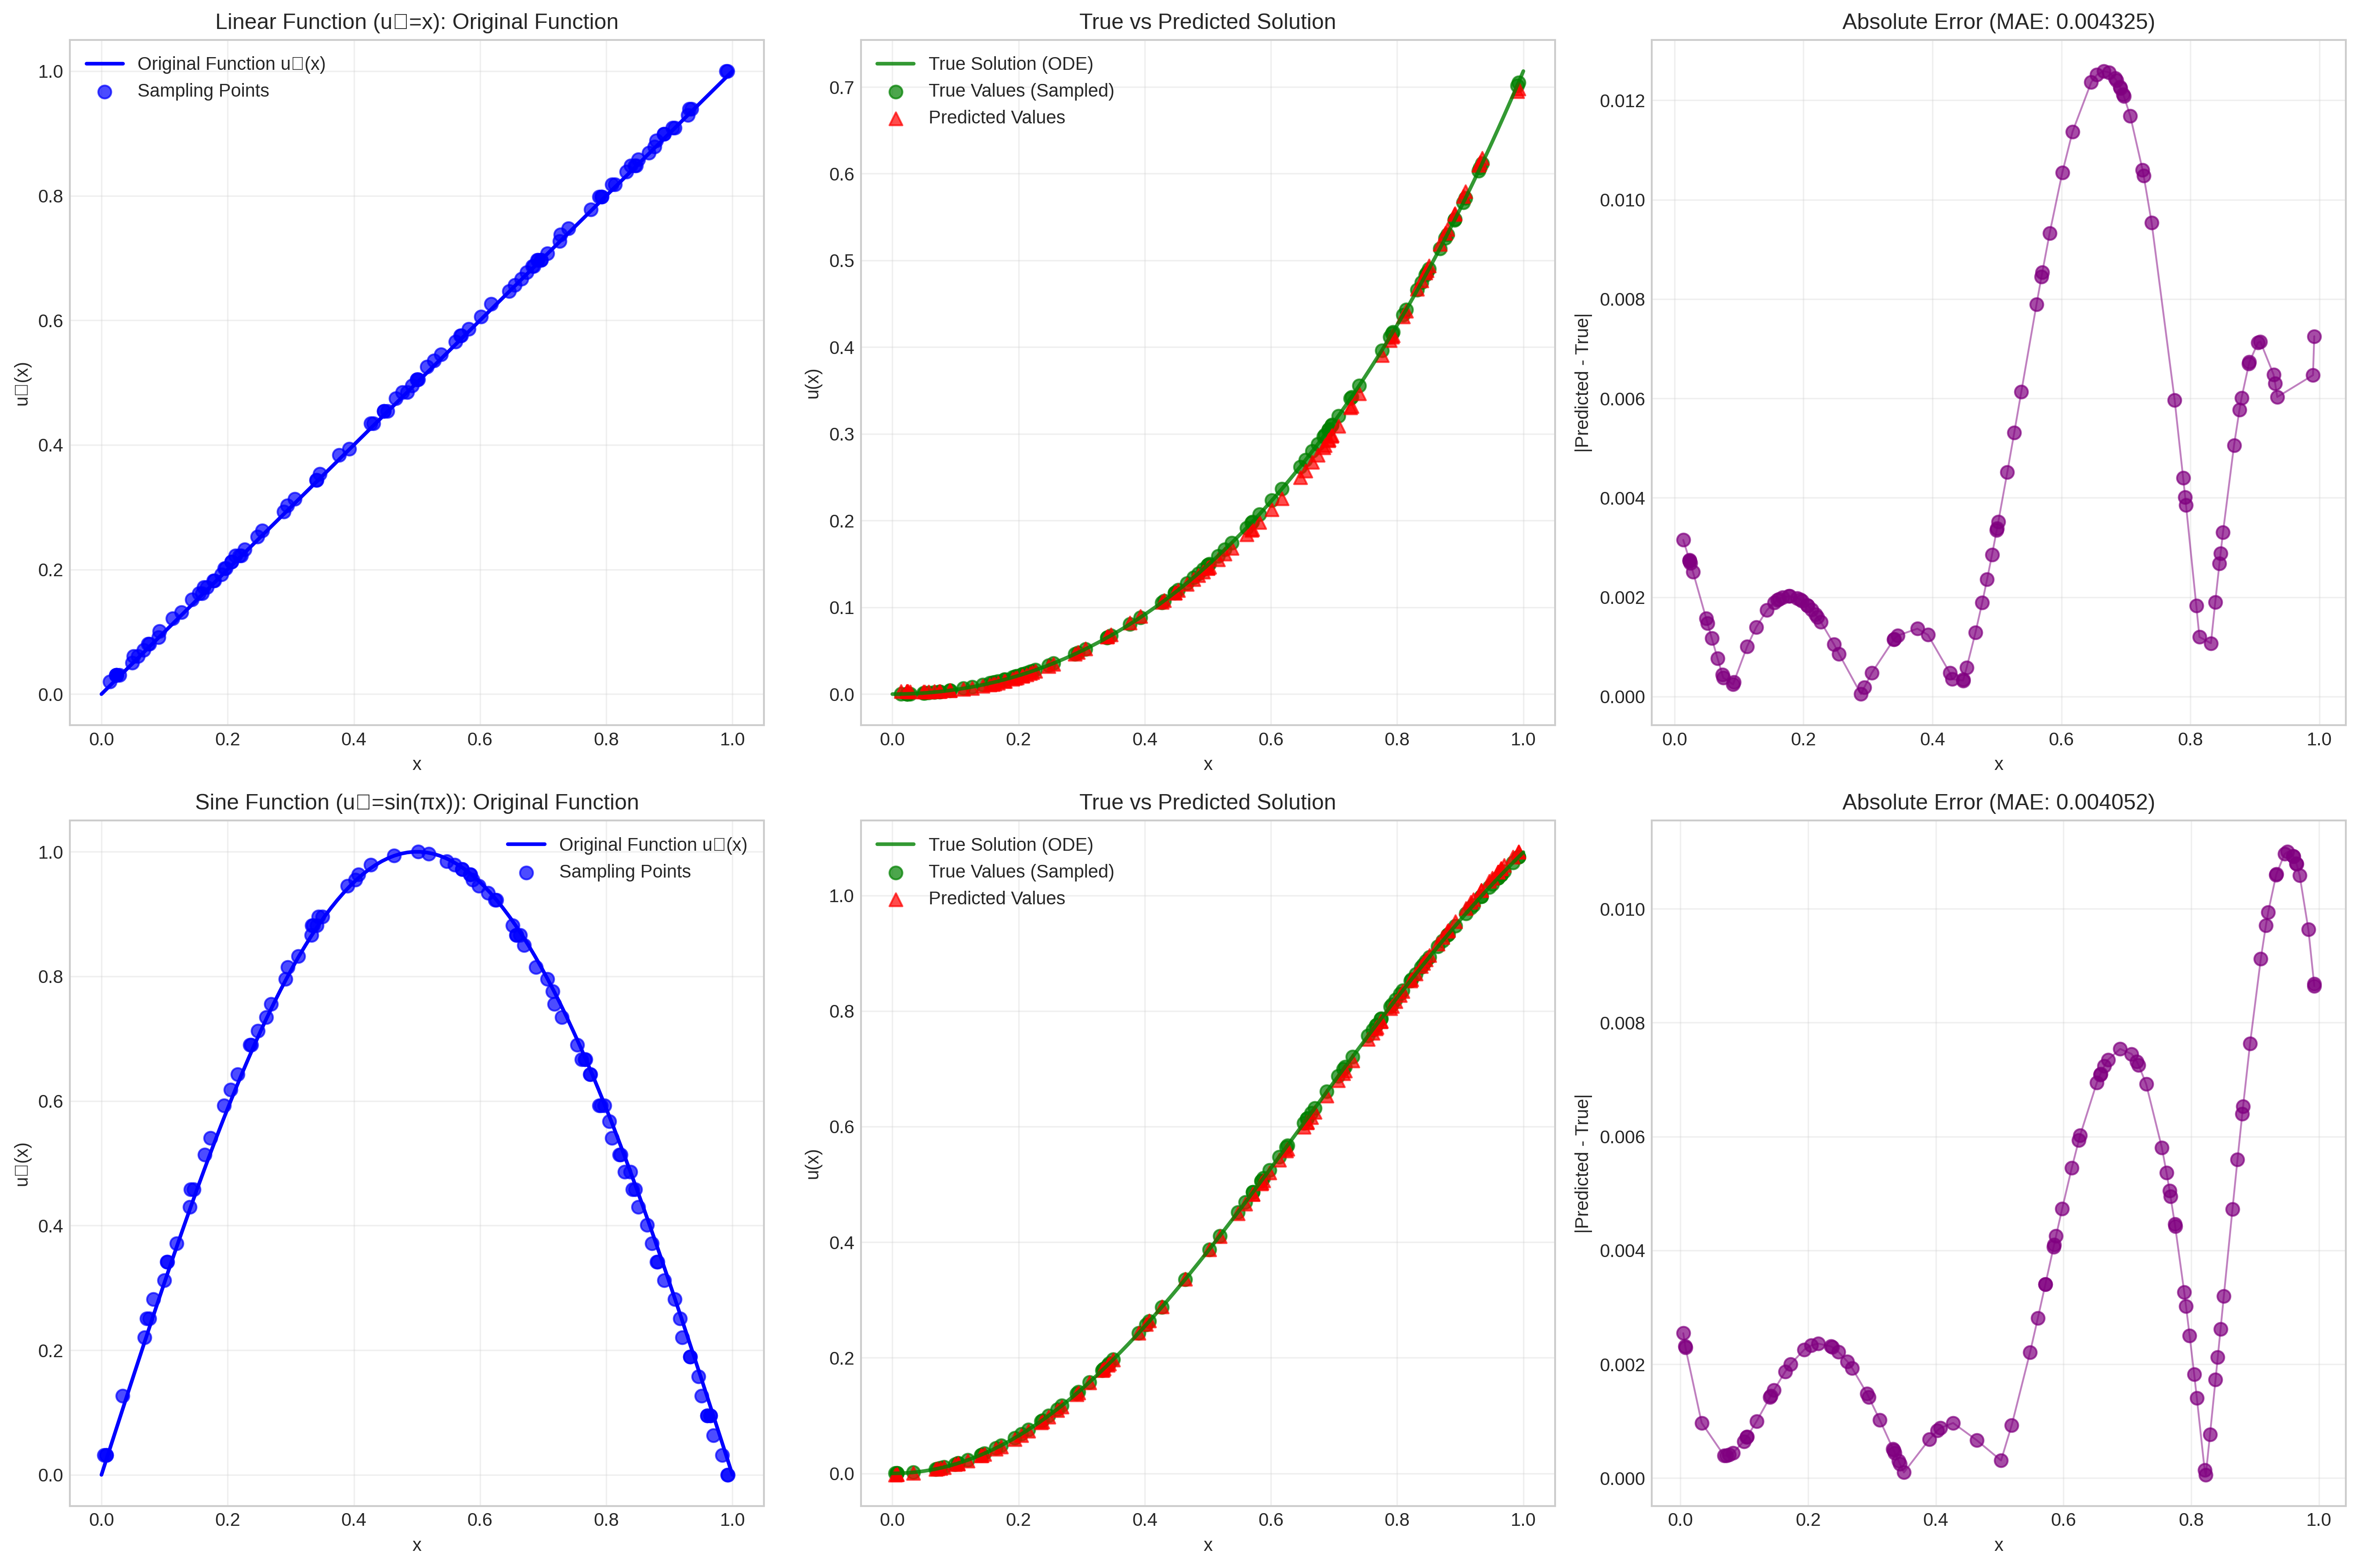

🎨 生成数据集随机样本对比图...
⚠️ 原始函数数据不可用，通过 branch_input 插值重建输入函数


📊 图表已保存: visualization_results/sample_2_comparison.png


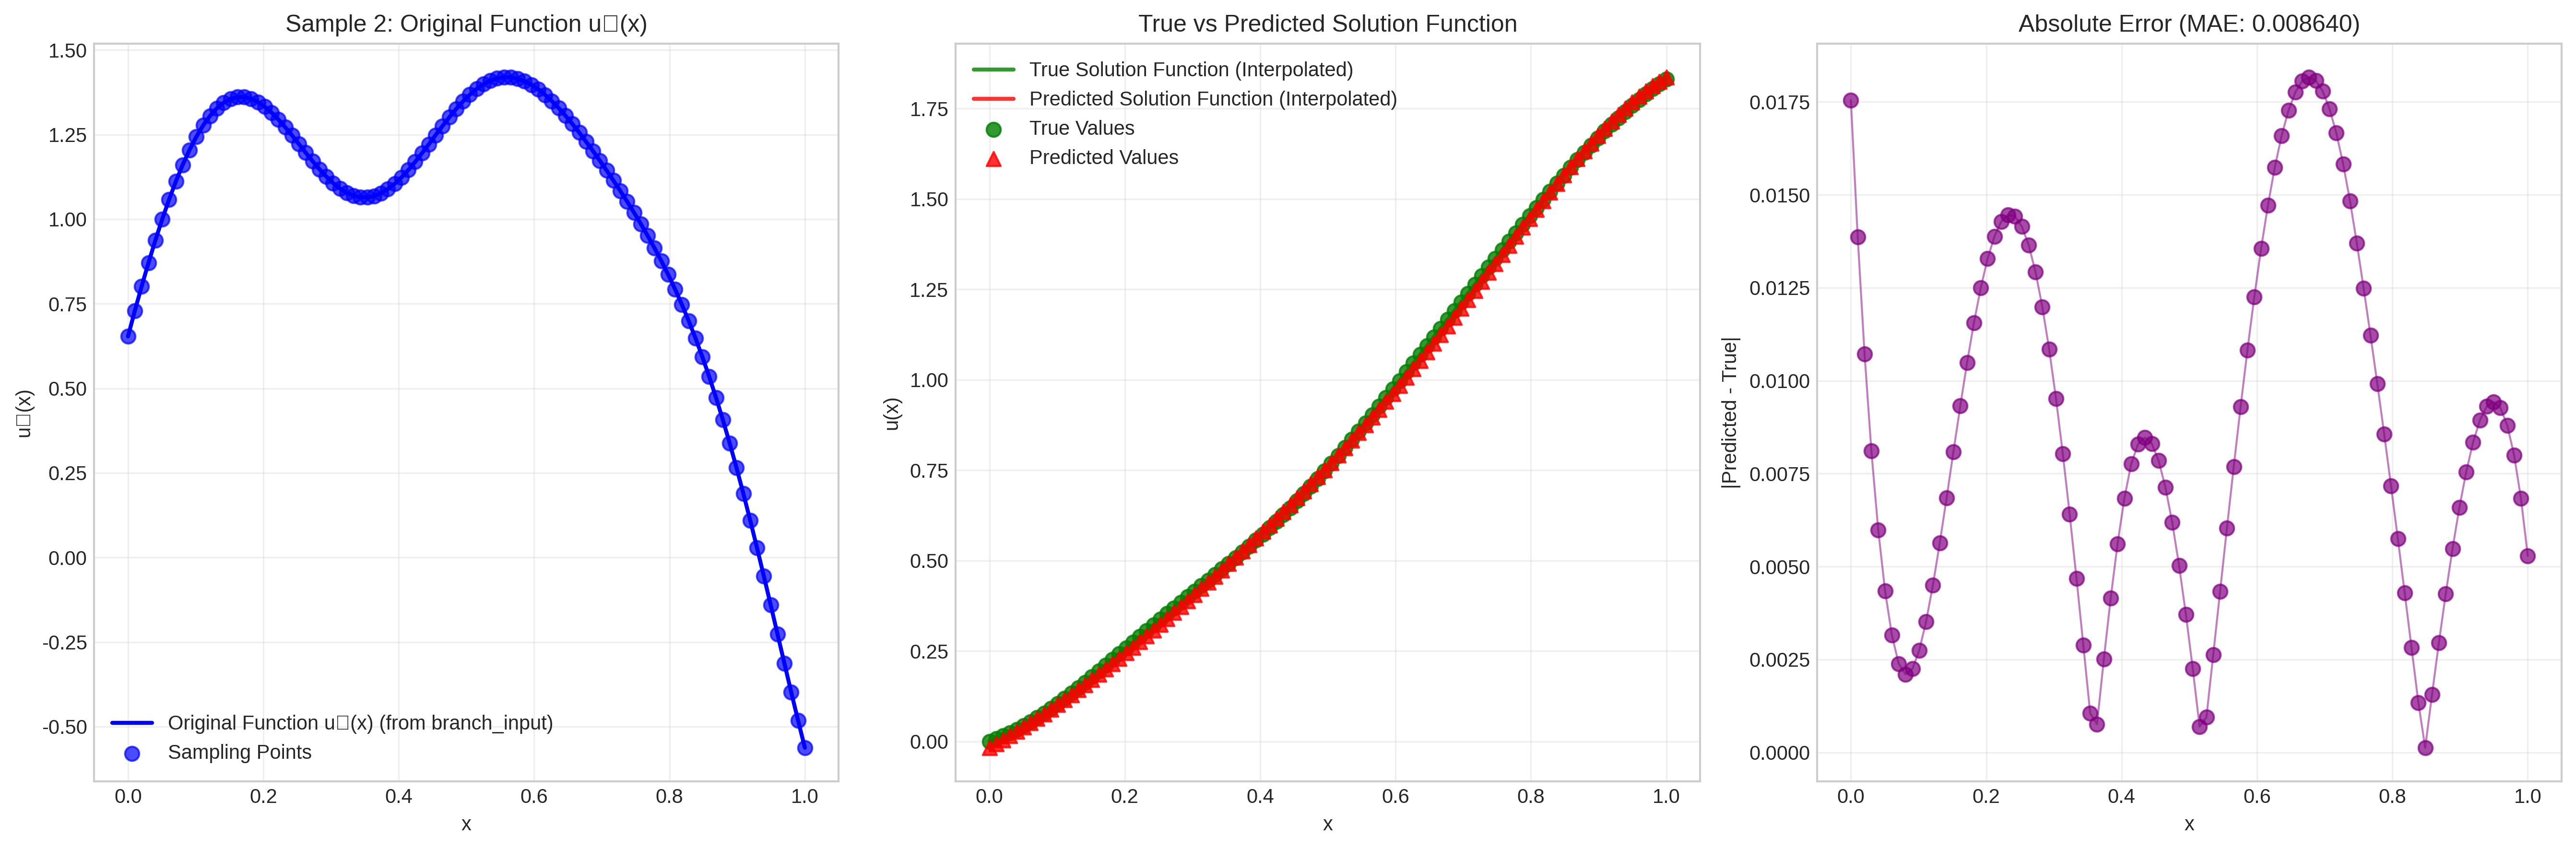

⚠️ 原始函数数据不可用，通过 branch_input 插值重建输入函数
📊 图表已保存: visualization_results/sample_7_comparison.png


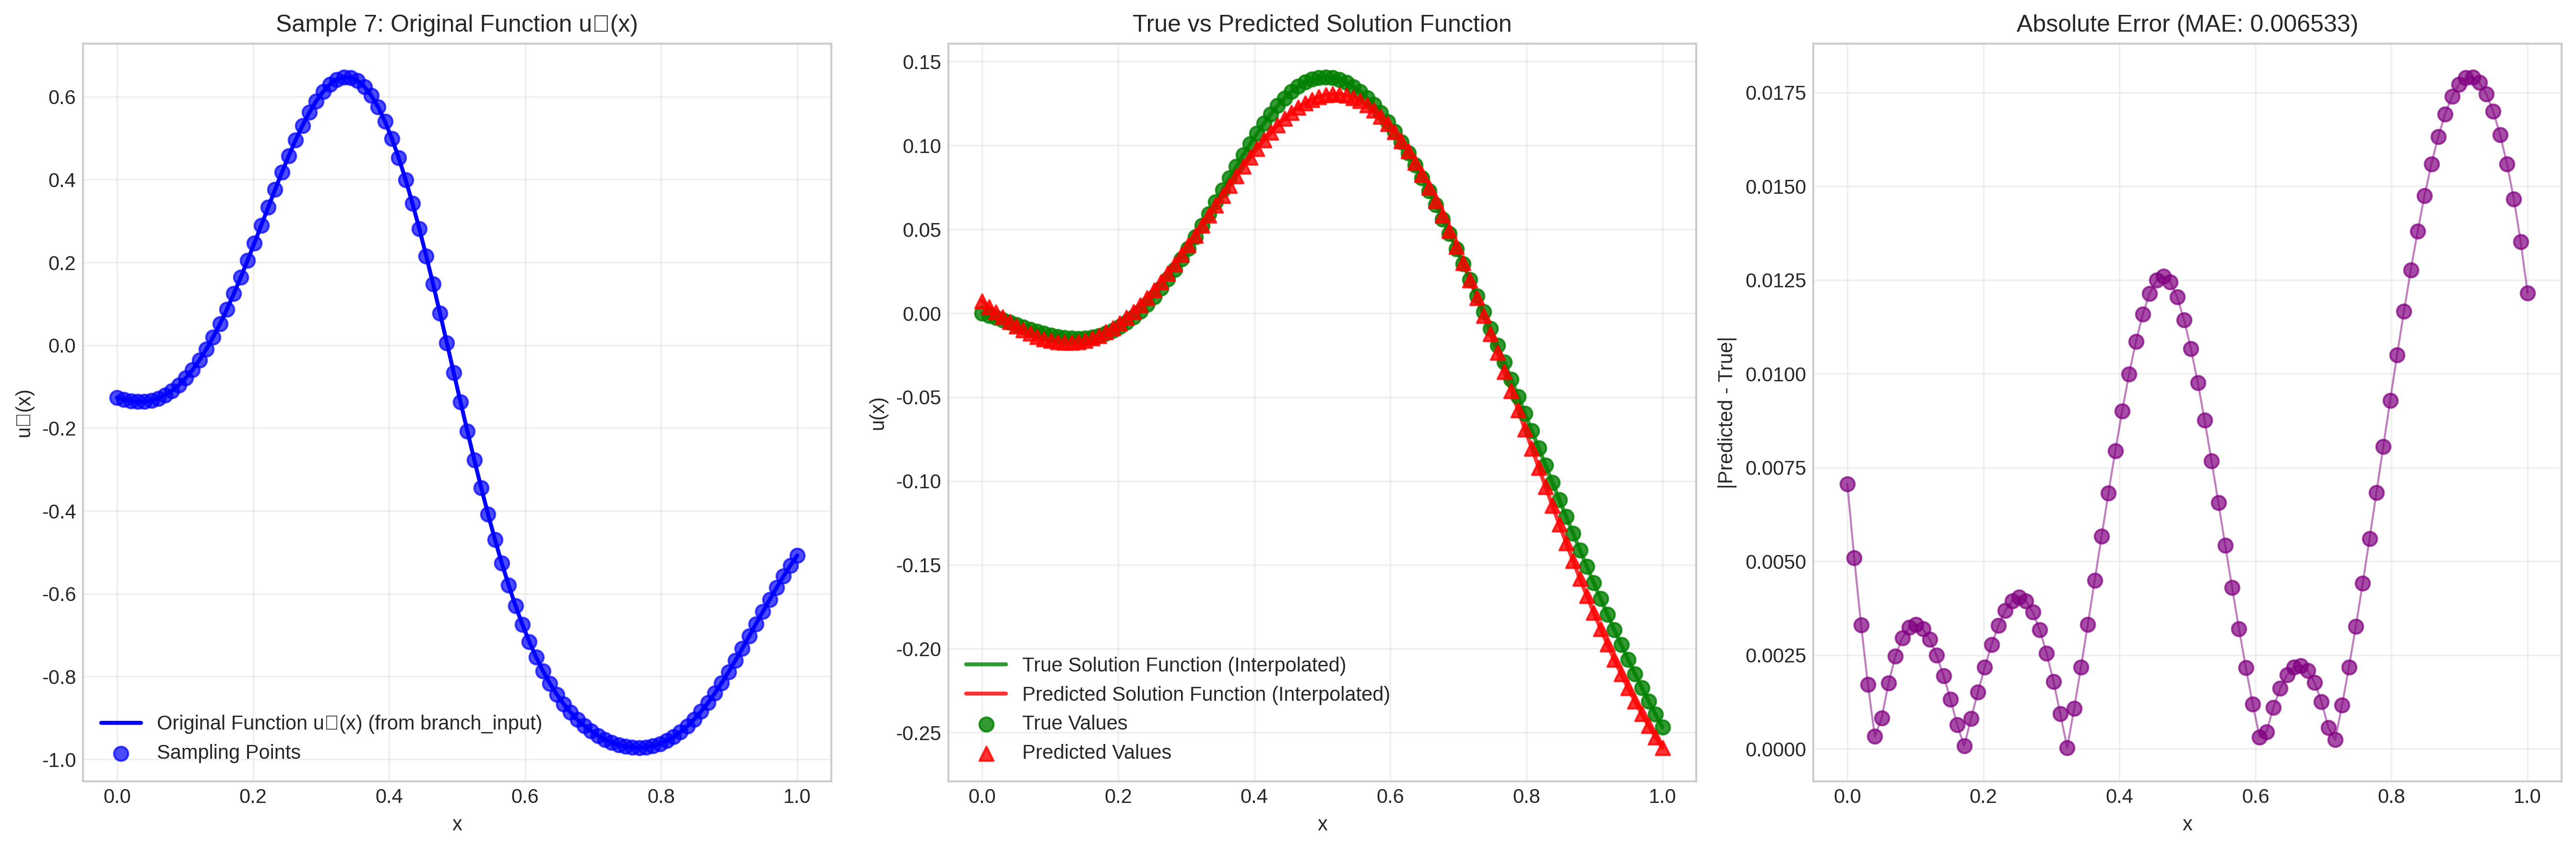

✅ 单样本对比图生成完成!


In [6]:
# Generate visualization comparisons with horizontal layout
if results and data and config and model:
    os.makedirs("visualization_results", exist_ok=True)
    
    # 1. Generate special functions comparison (construct u0=x and u0=sin(πx))
    print("🎨 构造并预测特定函数 (u₀=x 和 u₀=sin(πx))...")
    save_path = "visualization_results/special_functions_comparison.png"
    special_results = plot_special_functions_comparison(model, config, save_path)
    
    # 2. Generate random sample comparisons from existing dataset
    print("🎨 生成数据集随机样本对比图...")
    sample_indices = [2, 7]  # Two random samples
    
    for sample_idx in sample_indices:
        save_path = f"visualization_results/sample_{sample_idx}_comparison.png"
        plot_single_sample_comparison(sample_idx, data, results, config, save_path)
    
    print(f"✅ 单样本对比图生成完成!")
else:
    print("❌ 请确保已加载模型、数据并生成预测结果!")

## 7. Visualization Results

The notebook generates comprehensive visualizations with a new horizontal layout design:

### Generated Plots:

#### **Special Functions Analysis**:
- **`special_functions_comparison.png`** - Analysis of constructed specific test functions:
  - **u₀(x) = x** (Linear function) - directly constructed and predicted by the network
  - **u₀(x) = sin(πx)** (Sine function) - directly constructed and predicted by the network
  - Shows theoretical numerical solutions vs neural network predictions

#### **Random Sample Analysis**:
- **`sample_{idx}_comparison.png`** - Detailed analysis of randomly selected samples from the dataset

#### **Multi-Sample Overview**:
- **`multiple_samples_grid.png`** - Grid comparison of 4 representative samples from the dataset
- **`error_analysis.png`** - Comprehensive error distribution analysis

### Layout Design:
- **Horizontal Layout**: Each analysis uses three plots arranged horizontally:
  1. **Left**: Original function u₀(x) (input)
  2. **Center**: True vs Predicted solution function u(x) satisfying du/dx = u + u₀(x)  
  3. **Right**: Absolute error distribution

### Special Functions Implementation:
- **Direct Construction**: u₀=x and u₀=sin(πx) are mathematically constructed (not searched from dataset)
- **Numerical Solutions**: True solutions are obtained by solving the differential equation du/dx = u + u₀(x) numerically using scipy.integrate.solve_ivp
- **Network Prediction**: Functions are encoded and fed to the trained neural network
- **Comparison**: Network predictions are compared against numerically computed solutions

### Key Features:
- **English labels**: All chart titles, axis labels, and legends use English
- **Chinese output**: Print statements and console messages use Chinese
- **Mathematical rigor**: Uses numerically computed solutions for verification
- **Comprehensive coverage**: Constructed mathematical functions + dataset samples
- **Clear visualization**: Horizontal layout for better comparison

All files are automatically saved in the `visualization_results/` directory with high-resolution PNG format.

## Usage Instructions

### Optimized Workflow:
1. **Library import**: Execute Section 1 to import all required libraries
2. **Data loading**: Execute Section 2 to load configuration and data
3. **Model loading**: Execute Section 3 to load the trained QuanONet model  
4. **Generate predictions**: Execute Section 4 to generate model predictions
5. **Define visualization functions**: Execute Section 5 to set up plotting functions
6. **Single sample analysis**: Execute Section 6 for detailed individual sample comparisons
7. **Comprehensive visualization**: Execute Section 7 for complete analysis and error evaluation

### Key Improvements:
- **Reduced redundancy**: Removed duplicate plotting functions and unnecessary debug output
- **Bilingual interface**: Charts in English, console output in Chinese
- **Streamlined output**: Only essential information is displayed
- **Focused analysis**: Concentrates on the most informative visualizations

The notebook now provides a clean, efficient workflow for analyzing inverse operator neural network performance.